# Dilated Convolutions

**Abstract: Dilated Convolutions**:  
    "State-of-the-art models for semantic segmentation are based on adaptations of convolutional networks that had originally been designed for image classification. However, dense prediction and image classification are structurally different. In this work, we develop a new convolutional network module that is specifically designed for dense prediction. The presented module uses dilated convolutions to systematically aggregate multi-scale contextual information without losing resolution. The architecture is based on the fact that dilated convolutions support exponential expansion of the receptive field without loss of resolution or coverage. We show that the presented context module increases the accuracy of state-of-the-art semantic segmentation systems. In addition, we examine the adaptation of image classification networks to dense prediction and show that simplifying the adapted network can increase accuracy."  

https://arxiv.org/abs/1511.07122  

**Abstract: Dilated Residual Network**
    "Convolutional networks for image classification progressively reduce resolution until the image is represented by tiny feature maps in which the spatial structure of the scene is no longer discernible. Such loss of spatial acuity can limit image classification accuracy and complicate the transfer of the model to downstream applications that require detailed scene understanding. These problems can be alleviated by dilation, which increases the resolution of output feature maps without reducing the receptive field of individual neurons. We show that dilated residual networks (DRNs) outperform their non-dilated counterparts in image classification without increasing the model's depth or complexity. We then study gridding artifacts introduced by dilation, develop an approach to removing these artifacts ('degridding'), and show that this further increases the performance of DRNs. In addition, we show that the accuracy advantage of DRNs is further magnified in downstream applications such as object localization and semantic segmentation."   
    
  
https://arxiv.org/abs/1705.09914    

In [1]:
%matplotlib inline
import os, sys, math
import numpy as np
import matplotlib.pyplot as plt
import pylab
from random import randint, choice, seed
from cv2 import resize, imread, imwrite, cvtColor, INTER_NEAREST, INTER_CUBIC, IMREAD_COLOR, COLOR_BGR2RGB

# COCO dataset API
from pycocotools.coco import COCO

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.models as models

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Image augmentation
import imgaug as ia
from imgaug import augmenters as iaa

In [2]:
# # set seed
# torch.manual_seed(1)

# define data set location
dataDir='/home/jeff/Documents/data_sets/coco' # modify this path appropriatly to your downloaded coco dataset
dataType=['train2017','val2017']
train_annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType[0])
test_annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType[1])

# initialize COCO api for instance annotations
coco_train=COCO(train_annFile)
coco_test=COCO(test_annFile)

loading annotations into memory...
Done (t=13.69s)
creating index...
index created!
loading annotations into memory...
Done (t=0.44s)
creating index...
index created!


In [3]:
class COCO_dataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, list_IDs, data_split, object_classes, coco_API, im_width, im_height, data_dir, cache_dir, transform = None, augment = None):
        'Initialization'
        self.list_IDs = list_IDs
        self.data_split = data_split
        self.data_dir = data_dir
        self.coco_API = coco_API
        self.cache_dir = cache_dir
        
        self.im_width = im_width
        self.im_height = im_height
        
        # make dictionary of object_classes
        self.objects_dict = dict()
        for i,obj in enumerate(object_classes):
            self.objects_dict.update({obj:i+1})

        # get coco category IDs
        self.COCO_id_dict = dict()
        for obj in object_classes:
            obj_id = coco_train.getCatIds(catNms=obj);
            self.COCO_id_dict.update({obj_id[0]:obj})
        
        # define augmentations
        self.augment = augment
        
        # define transformations
        self.transform = transform
            
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]
        ID = int(ID)
        
        # read image from cache and check to see if it exists.
        X = imread(os.path.join(self.cache_dir, self.data_split, str(ID) + '.jpg'), IMREAD_COLOR)
        
        try:
            # if X is an array: the image is in the cache, and we will pass over the except statement
            X.any()

        except AttributeError:
            # If X is not an array: the image is not in the cache.
            # we will load and save the image and mask into the cache            
                
            # Load data and get label
            img = self.coco_API.loadImgs([ID])[0]
            X = imread(os.path.join(self.data_dir, 'images', self.data_split, img['file_name']), IMREAD_COLOR)
            X = cvtColor(X, COLOR_BGR2RGB)

            # generate the GT mask image
            h,w,c = X.shape
            y = np.zeros((h,w))

            # load GT of requested image with only the desired objects labeled
            annIds = self.coco_API.getAnnIds(imgIds=[ID], catIds=self.COCO_id_dict.keys(), iscrowd=False)
            annotations = self.coco_API.loadAnns(annIds)

            # replace COCO label with objects_dict label
            for ann in annotations:
                object_name = self.COCO_id_dict[ann['category_id']]
                objet_label = self.objects_dict[object_name]
                gt = self.coco_API.annToMask(ann)
                y[gt == 1] = objet_label

            imwrite(os.path.join(self.cache_dir, self.data_split, str(ID) + '.jpg'), X)
            imwrite(os.path.join(self.cache_dir, self.data_split, str(ID) + '.png'), y)
            
            # crop images to same size
            X,y = COCO_dataset.Random_Sized_Crop(X, y, self.im_width, self.im_height, static = True)
            
            # add dimenstion to mask as H * W * C
            y = y[...,np.newaxis]

            # apply requested augmentations
            if self.augment:
                random_integer = randint(1,1001)
                X,y = self.augment(X, y, random_integer)

            # convert images to C * H * W
            X = X.transpose((2, 0, 1))
            y = y.transpose((2, 0, 1))
                
            # package into dictionary  
            sample = {'image':X.astype(np.float), 'mask':y.astype(np.float)}

            # apply requested transformations
            if self.transform:
                sample = self.transform(sample)

            return sample
        
        # read images if cache is not empty
        y = imread(os.path.join(self.cache_dir, self.data_split, str(ID) + '.png'))

        y = y[:,:,0]
        
        # crop images to same size
        X,y = COCO_dataset.Random_Sized_Crop(X, y, self.im_width, self.im_height, static = False)

        # add dimenstion to mask as H * W * C
        y = y[...,np.newaxis]

        # apply requested augmentations
        if self.augment:
            random_integer = randint(1,1001)
            X,y = self.augment(X, y, random_integer)

        # convert images to C * H * W
        X = X.transpose((2, 0, 1))
        y = y.transpose((2, 0, 1))
        
        # package into dictionary  
        sample = {'image':X.astype(np.float), 'mask':y.astype(np.float)}

        # apply requested transformations
        if self.transform:
            sample = self.transform(sample)

        return sample
    
    @staticmethod
    def get_classifier_data(object_classes, coco_API):
        '''
        After initialization, the function get_classifier_data is called to generate the dataframe of images that
        contain the classes desired by user
        '''
        # get list of images that contain the desired categories
        data = set()
        for cat in object_classes:
            classId = coco_API.getCatIds(catNms=cat)
            imageIds = coco_API.getImgIds(catIds=classId)
            data.update(imageIds)

        # convert to dataframe and add labels
        data = np.array(list(data), dtype=str)

        return data
    
    @staticmethod
    def find_bad_images(image_list, data_dir, data_split, object_classes, coco_API):
        # find B&W images and Images where mask dims != iamge dims, then remove from training and validation images
        bad_images = []
        for im_Number in image_list:
            # get image number
            im_Number = int(im_Number)

            # read the original image
            img = coco_API.loadImgs(im_Number)[0]
            data_arr = imread(os.path.join(data_dir, 'images', data_split, img['file_name']), IMREAD_COLOR)
            data_arr = cvtColor(data_arr, COLOR_BGR2RGB)

            # read instance annotation
            gt = np.zeros((data_arr.shape[0],data_arr.shape[1]))
            mask = []
            for cat in object_classes:
                catIds = coco_API.getCatIds(catNms=cat);
                annIds = coco_API.getAnnIds(imgIds=[im_Number], catIds=catIds, iscrowd=False)
                anns = coco_API.loadAnns(annIds)
                for ann in anns:
                    mask = coco_API.annToMask(ann)
                    gt[mask == 1] = 1

            # some images have no postivie targets
            if isinstance(mask, list):
#                 print 'bad mask {}'.format(im_Number)
                bad_images.append(str(im_Number))

            # check that the image and mask have the same dimensions
            elif (mask.shape[:2] != data_arr.shape[:2]):
#                 print 'mask shape != image shape {}'.format(im_Number)            
                bad_images.append(str(im_Number))

            # some B&W images have onle 1 channel            
            elif len(data_arr.shape) != 3:
#                 print 'black and white image {}'.format(im_Number)
                bad_images.append(str(im_Number))

            # some B&W images have 3 channels, but they are all equivalent
            elif np.array_equal(data_arr[:,:,0],data_arr[:,:,1]):
#                 print 'black and white image {}'.format(im_Number)
                bad_images.append(str(im_Number))

            else:
                continue

        return bad_images
    
    @staticmethod
    def Random_Sized_Crop(img, mask, width=224, height=224, static = False):
        # define random crop transformation for image augmentation
        # Images in cv2 are defined as columns by rows [width x height]

        if static:
            seed(777)

        assert img.shape[0] == mask.shape[0]
        assert img.shape[1] == mask.shape[1]

        if img.shape[1] < width:
            img = resize(img, (width, img.shape[0]), interpolation = INTER_CUBIC)
            mask = resize(mask, (width, mask.shape[0]), interpolation = INTER_NEAREST)   

        if img.shape[0] < height:
            img = resize(img, (img.shape[1], height), interpolation = INTER_CUBIC)
            mask = resize(mask, (mask.shape[1], height), interpolation = INTER_NEAREST)        

        x = randint(0, img.shape[1] - width)
        y = randint(0, img.shape[0] - height)

        img = img[y:y+height, x:x+width]
        mask = mask[y:y+height, x:x+width]

        return img, mask

## Network Architecture



## Pre-processing
 

## Data Augmentation


In [4]:
class data_augment(object):
    
    def __init__(self):      
        self.seq = iaa.SomeOf((0,2),[iaa.SomeOf(1,[iaa.Affine(rotate=90,order=[0]),
                                                   iaa.Affine(rotate=(-25, 25),order=[0])],random_order=True),
                                     iaa.SomeOf(1,[iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}),
                                                   iaa.Affine(shear=(-8,8),order=[0])],random_order=True),
                                     iaa.SomeOf(1,[iaa.Fliplr(0.5),
                                                   iaa.Flipud(0.5)],random_order=True),
                                                   iaa.Affine(scale=(0.8,1.5),order=[0])    ])

    def __call__(self, image, mask, random_integer):
        # you MUST re-set the ia.seed before each call to seq.augment_image
        ia.seed(random_integer)
        image_aug = self.seq.augment_image(image)
        
        # you MUST re-set the ia.seed before each call to seq.augment_image
        ia.seed(random_integer)
        mask_aug = self.seq.augment_image(mask)

        return image_aug, mask_aug
        
class ToTensor(object):
    """
    convert ndarrays in sample to Tensors
    """
    def __call__(self,sample):
        image,mask = sample['image'],sample['mask']
        
        return {'image':torch.from_numpy(image.astype(np.float)),
               'mask':torch.from_numpy(mask.astype(np.float))}

## Training 

Training  was  performed  by  stochastic  gradient  descent  (SGD)  with:  
  
* mini-batch  size  14,  
* learning rate 10e−3, and  
* momentum 0.9.  
  
The network was trained for 60K iterations.

In [5]:
class net_training(object):
    '''
    Class for training the Segnet Model
    ~
    | __init__ defines the parameters for training SegNet
    | __call__ performs the training of SegNet 
    ~
    '''
    def __init__(self, object_label_dict, train_dataloader, test_dataloader, model, im_H, im_W, device = 'cuda', channel_means = [0.494, 0.4394, 0.371], channel_std = [0.142, 0.133, 0.136]):# Set parameters for classes used in training model
        '''
        im_height, im_width = height and width of the input image
        
        Channel_means and Channel_std will be re-defined if 
        
        TODO: change to cross entropy loss function
        '''
        
        self.object_label_dict = object_label_dict.copy()
        self.object_label_dict.update({'background':0})

        self.num_classes = len(self.object_label_dict)

        self.device = device
        
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        
        self.channel_means = channel_means
        self.channel_std = channel_std
        
        self.model = model(3, self.num_classes, im_H, im_W).to('cuda')

        # initialize weights
        self.model = self.model.apply(net_training.weights_init)
        
        # pre-train with VGG16
#         self.model = net_training.pre_train_initial_layers(self.model, models.vgg16_bn)

    @staticmethod
    def pre_train_initial_layers(my_model, trained_model):
        ###### pretrain SegNet with VGG16 #####
        print 'initalizing model with pre-trained weights'
        
        # load our model and get state dictionary
        model_state_dict = my_model.state_dict()

        # load the pre-trained model and get state dictionary to replace weights from some layers
        trained_VGG16 = trained_model(pretrained=True)
        trained_VGG16_state_dict = trained_VGG16.state_dict()

        # match layers from our model with layers from pre-trained model
        pretrained_dict = zip(model_state_dict.keys(), trained_VGG16_state_dict.values()[:-6])

        # overwrite entries in our model's existing state dict
        model_state_dict.update(pretrained_dict) 

        # load the new state dict into our model
        my_model.load_state_dict(model_state_dict)
        
        return my_model

    def define_loss_function(self, loss_fun = nn.CrossEntropyLoss, **kwargs):
        '''
        define loss function
        
        '''
        self.loss_function = loss_fun(**kwargs)
        
    def define_optimizer(self, optimizer_fun = optim.SGD, patience = 5,  **kwargs):
        '''
        define training optimizer
        
        TODO: set weight decay to 0 to remove L2 regularization
        
        TODO: Learning rate scheduler
        '''
        self.optimizer = optimizer_fun(self.model.parameters(), **kwargs)
        self.scheduler = optim.lr_scheduler.MultiStepLR(self.optimizer, milestones=[500], gamma=0.1)

    @staticmethod
    def weights_init(model):
        '''
        Initalize kernel and batch normalization weights
        '''
        # traverse all Modules, and, upon __class__.__name__ matching, you initialise the parameters with what you prefer.
        for m in model.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_() 

    def class_weight_channel_means(self, num_epochs = 1):
        all_classes = self.object_label_dict.keys()
        
        class_representation = {c:0 for c in all_classes}
        
        channel_means = {'channel_1':[0.0,0.0], 'channel_2':[0.0,0.0], 'channel_3':[0.0,0.0]}

        print "computing class weights"
        for i_epoch,epoch in enumerate(range(num_epochs)):
            # notify user of epoch
            print 'Starting epoch # %i of class weights computation' %(i_epoch+1)

            batch_channel_means = []
            #iterate though data
            for i_batch, sample_batched in enumerate(self.train_dataloader):
                image = sample_batched['image']
                mask = sample_batched['mask']

                # sum label pixels to obtain class representations
                for key,value in self.object_label_dict.items():
                    num_pixels = len(mask[mask==value])
                    class_representation[key] += num_pixels
        
        # compute weights
        weight_dict = {}
        for class_name, num_pixels in class_representation.items():
            if num_pixels != 0.0:
                weight_dict.update({class_name: float( max( class_representation.values() ) ) / num_pixels})
            else: 
                weight_dict.update({class_name: 0.0})

        for key,value in weight_dict.items():
                print '\nThe class weight for {} is {} \n'.format(key, value)

        print weight_dict
        
        # return weight vector to user
        return weight_dict

    def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
        torch.save(state, filename)
        if is_best:
            shutil.copyfile(filename, 'model_best.pth.tar')
    
    def train(self, num_epochs, save_checkpoint_path, final_model_path, resume = False, num_test_plots = 8):
        '''
        Start training the model. 
        plost progress after every `progress_num` batches
        '''
        losses = []
        ave_test_accuracy = []
        last_stop = 1
        best_test_accuracy = 0.0
        
        if resume == True:
            state = torch.load(save_checkpoint_path)
            self.model.load_state_dict(state['state_dict'])
            self.optimizer.load_state_dict(state['optimizer'])                    
            self.scheduler.load_state_dict(state['scheduler'])
            last_stop = state['epoch']
            print 'resuming training from last epoch {}'.format(last_stop)

        for epoch in range(num_epochs):
            print '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'
            print 'Starting Epoch # %i' %(epoch+last_stop)

            #iterate though data
            for i_batch, sample_batched in enumerate(self.train_dataloader):
                images = sample_batched['image'].float().to(self.device)
                masks = sample_batched['mask'].long().to(self.device)

                # We need to clear gradients before each instance
                self.model.zero_grad()

                # Run our forward pass.
                score = self.model(images)
                
                masks
                # Compute the loss, gradients, and update the parameters by
                loss = self.loss_function(score, torch.squeeze(masks,1))
                loss.backward()
                self.optimizer.step()    # Does the update

            if epoch%5 == 0:
                #compile loss for each check-point
                loss = torch.Tensor.cpu(loss)
                losses.append(loss.data.numpy())

                #compile test accuracies for each check-point
                with torch.no_grad():
                    print 'testing results'

                    fig, ax = plt.subplots(3, num_test_plots, figsize = (20,6))
                    test_acc = []

                    for i_test, test_sample_batched in enumerate(self.test_dataloader):
                        test_image = test_sample_batched['image'].float().to(self.device)
                        test_mask = test_sample_batched['mask'].long().to(self.device)

                        # Run our forward pass and save score for learning rate scheduler.
                        score = self.model(test_image)
                        
                        # ontain the mask and algorithm result for computing accuracy
                        test_mask = test_mask.squeeze().detach().cpu().numpy()
                        
                        output = torch.argmax(score, dim = 1)
                        output = output[0].detach().cpu().numpy()
                        
                        # compute and store acuracy
                        acc = float(np.sum(output == test_mask)) / (test_mask.shape[0] * test_mask.shape[1])
                        test_acc.append(acc)
                        
                        # print results for first n images
                        if i_test in range(num_test_plots):

                            plot_img = test_image.squeeze().detach().cpu()                          
                            plot_img = np.asarray(plot_img, dtype=np.uint8).transpose((1, 2, 0))

                            ax[0,i_test].imshow(plot_img)
                            ax[0,i_test].axis('off')

                            ax[1,i_test].imshow(output, clim=(0, self.num_classes))
                            ax[1,i_test].axis('off')

                            ax[2,i_test].imshow(test_mask, clim=(0, self.num_classes))
                            ax[2,i_test].axis('off')

                # show plot
                plt.show()

                # append test_accuracy to list for later
                ave_test_accuracy.append(np.mean(test_acc))

                # update the learning rate scheduler
                self.scheduler.step(np.mean(test_acc))

                # notify user of progress
                print 'Loss on epoch %i was: %.8f' %(epoch+last_stop, loss.data.numpy())
                print 'Test accuracy after epoch %i was: %.8f +/- %.8f' %(epoch+last_stop, np.mean(test_acc), np.std(test_acc))

                # save model to re-start training
                state = {'epoch': epoch+last_stop,
                         'state_dict': self.model.state_dict(),
                         'optimizer': self.optimizer.state_dict(),
                         'scheduler': self.scheduler.state_dict()}
                torch.save(state, save_checkpoint_path)
                
                # save the model for inferencing
                if ave_test_accuracy > best_test_accuracy:
                    torch.save(self.model.state_dict(), final_model_path)

        # print loss over each checkpoint
        fix, ax = plt.subplots()
        ax.plot(losses, label = 'loss')
        ax.plot(ave_test_accuracy, label = 'test accuracy')
        ax.legend(loc="lower left")
        plt.show()
        


In [6]:
# empty cache
train_cache = '/home/jeff/Documents/data_sets/coco_cache/train2017'
val_cache = '/home/jeff/Documents/data_sets/coco_cache/val2017'

filelist = [f for f in os.listdir(train_cache)]
for f in filelist:
    os.remove(os.path.join(train_cache, f))

filelist = [f for f in os.listdir(val_cache)]
for f in filelist:
    os.remove(os.path.join(val_cache, f))

# select object to detect
object_classes = ['zebra']

# Get training and testing images
training_data = COCO_dataset.get_classifier_data(object_classes, coco_train)
testing_data = COCO_dataset.get_classifier_data(object_classes, coco_test)

# Detect and remove bad images
training_bad_images = COCO_dataset.find_bad_images(training_data, dataDir, 'train2017' , object_classes, coco_train)
training_data = [im for im in training_data if im not in training_bad_images]

testing_bad_images = COCO_dataset.find_bad_images(testing_data, dataDir, 'val2017' , object_classes, coco_test)
testing_data = [im for im in testing_data if im not in testing_bad_images]

In [7]:
# Initialize Datasets
im_width = 512
im_height = 512

# define augmentation class
Faliu_aug = data_augment()

my_COCO_training_data = COCO_dataset(training_data, 
                                     'train2017', 
                                     object_classes, 
                                     coco_train,
                                     im_width,
                                     im_height,
                                     dataDir,
                                     cache_dir = '/home/jeff/Documents/data_sets/coco_cache/',
                                     transform = ToTensor(),
                                     augment = None) # Faliu_aug)

my_COCO_testing_data = COCO_dataset(testing_data, 
                                     'val2017', 
                                     object_classes, 
                                     coco_test,
                                     im_width,
                                     im_height,
                                     dataDir,
                                     cache_dir = '/home/jeff/Documents/data_sets/coco_cache/',
                                     transform = ToTensor(),
                                     augment = None)


# Initialize DataLoaders
train_dataloader = DataLoader(my_COCO_training_data, batch_size=4,
                        shuffle=True, num_workers=1)

test_dataloader = DataLoader(my_COCO_testing_data, batch_size=1,
                        shuffle=True, num_workers=1)


In [8]:
class drn(nn.Module):
    '''
    Based on: drn_d_54

    https://github.com/fyu/drn/blob/master/drn.py

    model = DRN(block = Bottleneck, 
                layers = [1, 1, 3, 4, 6, 3, 1, 1], 
                arch='D', 
                num_classes=1000,
                channels=(16, 32, 64, 128, 256, 512, 512, 512),
                out_map=False, 
                out_middle=False, 
                pool_size=28, 
                **kwargs)
    
    '''
    def __init__(self, im_channels, num_classes, im_H, im_W, pool_size=28):
        super(drn, self).__init__()
        
        self.im_H = im_H
        self.im_W = im_W
        self.num_classes = num_classes
        self.im_channels = im_channels
        
#         # pool layers are all the same, we can define once here
#         self.pool = nn.MaxPool2d((2,2), stride=2) # kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        
#         # drouput layers are all the same and can be defined once here
#         self.dropout = nn.Dropout(p=0.5, inplace=False)
        
#         # layers that upsample with pooling indices
#         self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

        # many ReLU functions are performed "inplace"
        self.iReLU = nn.ReLU(inplace=True)
        
        #### Encoder
        ## Layer 0
        self.conv0 = nn.Conv2d(self.im_channels, 16, kernel_size=7, stride=1, padding=3, bias=False)
        self.bn0 = nn.BatchNorm2d(16)
        # [16,256,256] c,h,w
        
        ## Layer 1
        self.conv1 = nn.Conv2d(16, 16, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        # [16,256,256] c,h,w
        
        ## Layer 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=2, bias=False)
        self.bn2 = nn.BatchNorm2d(32)      
        # [32,128,128] c,h,w
        
        ## Layer 3
            ## Block 1
                # downsample block
        self.conv3d = nn.Conv2d(32, 256, kernel_size=1, stride=2, bias=False)
        self.bn3d = nn.BatchNorm2d(256)
        # [256,64,64] c,h,w

        self.conv310 = nn.Conv2d(32, 64, kernel_size=1, stride=1, bias=False)
        self.bn310 = nn.BatchNorm2d(64)
        self.conv311 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, dilation=1, bias=False)
        self.bn311 = nn.BatchNorm2d(64)
        self.conv312 = nn.Conv2d(64, 256, kernel_size=1, stride=1, bias=False)
        self.bn312 = nn.BatchNorm2d(256)
        # [256,64,64] c,h,w

            ## Block 2
        self.conv320 = nn.Conv2d(256, 64, kernel_size=1, stride=1, bias=False)
        self.bn320 = nn.BatchNorm2d(64)
        self.conv321 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, dilation=1, bias=False)
        self.bn321 = nn.BatchNorm2d(64)
        self.conv322 = nn.Conv2d(64, 256, kernel_size=1, stride=1, bias=False)
        self.bn322 = nn.BatchNorm2d(256)
        # [256,64,64] c,h,w
        
            ## Block 3
        self.conv330 = nn.Conv2d(256, 64, kernel_size=1, stride=1, bias=False)
        self.bn330 = nn.BatchNorm2d(64)
        self.conv331 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, dilation=1, bias=False)
        self.bn331 = nn.BatchNorm2d(64)
        self.conv332 = nn.Conv2d(64, 256, kernel_size=1, stride=1, bias=False)
        self.bn332 = nn.BatchNorm2d(256)
        # [256,64,64] c,h,w
        
  
        ## Layer 4
            ## Block 1
                # downsample block
        self.conv4d = nn.Conv2d(256, 512, kernel_size=1, stride=2, bias=False)
        self.bn4d = nn.BatchNorm2d(512)
        # [512,32,32] c,h,w

        self.conv410 = nn.Conv2d(256, 128, kernel_size=1, stride=1, bias=False)
        self.bn410 = nn.BatchNorm2d(128)
        self.conv411 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1, dilation=1, bias=False)
        self.bn411 = nn.BatchNorm2d(128)
        self.conv412 = nn.Conv2d(128, 512, kernel_size=1, stride=1, bias=False)
        self.bn412 = nn.BatchNorm2d(512)
        # [512,32,32] c,h,w

            # Block 2
        self.conv420 = nn.Conv2d(512, 128, kernel_size=1, stride=1, bias=False)
        self.bn420 = nn.BatchNorm2d(128)
        self.conv421 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, dilation=1, bias=False)
        self.bn421 = nn.BatchNorm2d(128)
        self.conv422 = nn.Conv2d(128, 512, kernel_size=1, stride=1, bias=False)
        self.bn422 = nn.BatchNorm2d(512)
        # [512,32,32] c,h,w
        
            # Block 3
        self.conv430 = nn.Conv2d(512, 128, kernel_size=1, stride=1, bias=False)
        self.bn430 = nn.BatchNorm2d(128)
        self.conv431 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, dilation=1, bias=False)
        self.bn431 = nn.BatchNorm2d(128)
        self.conv432 = nn.Conv2d(128, 512, kernel_size=1, stride=1, bias=False)
        self.bn432 = nn.BatchNorm2d(512)
        # [512,32,32] c,h,w
        
            # Block 4
        self.conv440 = nn.Conv2d(512, 128, kernel_size=1, stride=1, bias=False)
        self.bn440 = nn.BatchNorm2d(128)
        self.conv441 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, dilation=1, bias=False)
        self.bn441 = nn.BatchNorm2d(128)
        self.conv442 = nn.Conv2d(128, 512, kernel_size=1, stride=1, bias=False)
        self.bn442 = nn.BatchNorm2d(512)
        # [512,32,32] c,h,w


        ## Layer 5
            ## Block 1
                # downsample block
        self.conv5d = nn.Conv2d(512, 1024, kernel_size=1, stride=1, bias=False)
        self.bn5d = nn.BatchNorm2d(1024)
        # [1024,16,16] c,h,w

        self.conv510 = nn.Conv2d(512, 256, kernel_size=1, stride=1, bias=False)
        self.bn510 = nn.BatchNorm2d(256)
        self.conv511 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=2, dilation=2, bias=False)
        self.bn511 = nn.BatchNorm2d(256)
        self.conv512 = nn.Conv2d(256, 1024, kernel_size=1, stride=1, bias=False)
        self.bn512 = nn.BatchNorm2d(1024)
        # [1024,16,16] c,h,w

            # Block 2
        self.conv520 = nn.Conv2d(1024, 256, kernel_size=1, stride=1, bias=False)
        self.bn520 = nn.BatchNorm2d(256)
        self.conv521 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=2, dilation=2, bias=False)
        self.bn521 = nn.BatchNorm2d(256)
        self.conv522 = nn.Conv2d(256, 1024, kernel_size=1, stride=1, bias=False)
        self.bn522 = nn.BatchNorm2d(1024)
        # [1024,16,16] c,h,w
        
            # Block 3
        self.conv530 = nn.Conv2d(1024, 256, kernel_size=1, stride=1, bias=False)
        self.bn530 = nn.BatchNorm2d(256)
        self.conv531 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=2, dilation=2, bias=False)
        self.bn531 = nn.BatchNorm2d(256)
        self.conv532 = nn.Conv2d(256, 1024, kernel_size=1, stride=1, bias=False)
        self.bn532 = nn.BatchNorm2d(1024)
        # [1024,16,16] c,h,w
        
            # Block 4
        self.conv540 = nn.Conv2d(1024, 256, kernel_size=1, stride=1, bias=False)
        self.bn540 = nn.BatchNorm2d(256)
        self.conv541 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=2, dilation=2, bias=False)
        self.bn541 = nn.BatchNorm2d(256)
        self.conv542 = nn.Conv2d(256, 1024, kernel_size=1, stride=1, bias=False)
        self.bn542 = nn.BatchNorm2d(1024)
        # [1024,16,16] c,h,w

            # Block 5
        self.conv550 = nn.Conv2d(1024, 256, kernel_size=1, stride=1, bias=False)
        self.bn550 = nn.BatchNorm2d(256)
        self.conv551 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=2, dilation=2, bias=False)
        self.bn551 = nn.BatchNorm2d(256)
        self.conv552 = nn.Conv2d(256, 1024, kernel_size=1, stride=1, bias=False)
        self.bn552 = nn.BatchNorm2d(1024)
        # [1024,16,16] c,h,w

            # Block 6
        self.conv560 = nn.Conv2d(1024, 256, kernel_size=1, stride=1, bias=False)
        self.bn560 = nn.BatchNorm2d(256)
        self.conv561 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=2, dilation=2, bias=False)
        self.bn561 = nn.BatchNorm2d(256)
        self.conv562 = nn.Conv2d(256, 1024, kernel_size=1, stride=1, bias=False)
        self.bn562 = nn.BatchNorm2d(1024)
        # [1024,16,16] c,h,w

        ## Layer 6
            ## Block 1
                # downsample block
        self.conv6d = nn.Conv2d(1024, 2048, kernel_size=1, stride=1, bias=False)
        self.bn6d = nn.BatchNorm2d(2048)
        # [2048,8,8] c,h,w

        self.conv610 = nn.Conv2d(1024, 512, kernel_size=1, stride=1, bias=False)
        self.bn610 = nn.BatchNorm2d(512)
        self.conv611 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=4, dilation=4, bias=False)
        self.bn611 = nn.BatchNorm2d(512)
        self.conv612 = nn.Conv2d(512, 2048, kernel_size=1, stride=1, bias=False)
        self.bn612 = nn.BatchNorm2d(2048)
        # [2048,8,8] c,h,w

            # Block 2
        self.conv620 = nn.Conv2d(2048, 512, kernel_size=1, stride=1, bias=False)
        self.bn620 = nn.BatchNorm2d(512)
        self.conv621 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=4, dilation=4, bias=False)
        self.bn621 = nn.BatchNorm2d(512)
        self.conv622 = nn.Conv2d(512, 2048, kernel_size=1, stride=1, bias=False)
        self.bn622 = nn.BatchNorm2d(2048)
        # [2048,8,8] c,h,w
        
            # Block 3
        self.conv630 = nn.Conv2d(2048, 512, kernel_size=1, stride=1, bias=False)
        self.bn630 = nn.BatchNorm2d(512)
        self.conv631 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=4, dilation=4, bias=False)
        self.bn631 = nn.BatchNorm2d(512)
        self.conv632 = nn.Conv2d(512, 2048, kernel_size=1, stride=1, bias=False)
        self.bn632 = nn.BatchNorm2d(2048)
        # [2048,8,8] c,h,w
        
         ## Layer 7
            ## Block 1
        self.conv710 = nn.Conv2d(2048, 512, kernel_size=3, stride=1, padding=2, dilation=2, bias=False)
        self.bn710 = nn.BatchNorm2d(512)
        # [512,8,8] c,h,w         
        
         ## Layer 8
            ## Block 1
        self.conv810 = nn.Conv2d(512, 512, kernel_size=1, stride=1, bias=False)
        self.bn810 = nn.BatchNorm2d(512)
        # [512,8,8] c,h,w
        
#         self.avgpool = nn.AvgPool2d(pool_size)
        self.fc = nn.Conv2d(512, num_classes, kernel_size=1, stride=1, padding=0, bias=True)

#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
#                 m.weight.data.normal_(0, math.sqrt(2. / n))
#             elif isinstance(m, nn.BatchNorm2d):
#                 m.weight.data.fill_(1)
#                 m.bias.data.zero_()        
        
    def forward(self, img):
        # initial layers 0, 1, 2
        x = self.iReLU(self.bn0(self.conv0(img)))
        x = self.iReLU(self.bn1(self.conv1(x)))
        x = self.iReLU(self.bn2(self.conv2(x))) # (bottleneck)
        
        # layer 3 (bottleneck)
        ## block 1
        residual = self.bn3d(self.conv3d(x))
        x = self.iReLU(self.bn310(self.conv310(x)))
        x = self.iReLU(self.bn311(self.conv311(x)))
        x = self.bn312(self.conv312(x))
        x += residual
        x = self.iReLU(x)
        ## block 2
        x = self.iReLU(self.bn320(self.conv320(x)))
        x = self.iReLU(self.bn321(self.conv321(x)))
        x = self.iReLU(self.bn322(self.conv322(x)))
        ## Block 3
        x = self.iReLU(self.bn330(self.conv330(x)))
        x = self.iReLU(self.bn331(self.conv331(x)))
        x = self.iReLU(self.bn332(self.conv332(x)))
        
        # layer 4 (bottleneck)
        ## block 1
        residual = self.bn4d(self.conv4d(x))
        x = self.iReLU(self.bn410(self.conv410(x)))
        x = self.iReLU(self.bn411(self.conv411(x)))
        x = self.bn412(self.conv412(x))
        x += residual
        x = self.iReLU(x)
        ## block 2
        x = self.iReLU(self.bn420(self.conv420(x)))
        x = self.iReLU(self.bn421(self.conv421(x)))
        x = self.iReLU(self.bn422(self.conv422(x)))
        ## Block 3
        x = self.iReLU(self.bn430(self.conv430(x)))
        x = self.iReLU(self.bn431(self.conv431(x)))
        x = self.iReLU(self.bn432(self.conv432(x)))
        ## block 4
        x = self.iReLU(self.bn440(self.conv440(x)))
        x = self.iReLU(self.bn441(self.conv441(x)))
        x = self.iReLU(self.bn442(self.conv442(x)))        

        # layer 5 (bottleneck)
        ## block 1
        residual = self.bn5d(self.conv5d(x))
        x = self.iReLU(self.bn510(self.conv510(x)))
        x = self.iReLU(self.bn511(self.conv511(x)))
        x = self.bn512(self.conv512(x))
        x += residual
        x = self.iReLU(x)
        ## block 2
        x = self.iReLU(self.bn520(self.conv520(x)))
        x = self.iReLU(self.bn521(self.conv521(x)))
        x = self.iReLU(self.bn522(self.conv522(x)))
        ## Block 3
        x = self.iReLU(self.bn530(self.conv530(x)))
        x = self.iReLU(self.bn531(self.conv531(x)))
        x = self.iReLU(self.bn532(self.conv532(x)))
        ## block 4
        x = self.iReLU(self.bn540(self.conv540(x)))
        x = self.iReLU(self.bn541(self.conv541(x)))
        x = self.iReLU(self.bn542(self.conv542(x)))  
        ## block 5
        x = self.iReLU(self.bn550(self.conv550(x)))
        x = self.iReLU(self.bn551(self.conv551(x)))
        x = self.iReLU(self.bn552(self.conv552(x))) 
        ## block 6
        x = self.iReLU(self.bn560(self.conv560(x)))
        x = self.iReLU(self.bn561(self.conv561(x)))
        x = self.iReLU(self.bn562(self.conv562(x))) 

        # layer 6 (bottleneck)
        ## block 1
        residual = self.bn6d(self.conv6d(x))
        x = self.iReLU(self.bn610(self.conv610(x)))
        x = self.iReLU(self.bn611(self.conv611(x)))
        x = self.bn612(self.conv612(x))
        x += residual
        x = self.iReLU(x)
        ## block 2
        x = self.iReLU(self.bn620(self.conv620(x)))
        x = self.iReLU(self.bn621(self.conv621(x)))
        x = self.iReLU(self.bn622(self.conv622(x)))
        ## Block 3
        x = self.iReLU(self.bn630(self.conv630(x)))
        x = self.iReLU(self.bn631(self.conv631(x)))
        x = self.iReLU(self.bn632(self.conv632(x)))

        # layer 7
        ## Block 3
        x = self.iReLU(self.bn710(self.conv710(x)))
        
        # layer 8
        ## Block 3
        x = self.iReLU(self.bn810(self.conv810(x)))
        
#         x = self.avgpool(x)

        x = self.fc(x)

#         x = x.view(x.size(0), -1)

        # bring image back to size of mask
        x = F.interpolate(x, size=(self.im_H,self.im_W))

        return x

In [9]:
my_net = net_training(object_label_dict = my_COCO_training_data.objects_dict, 
                            train_dataloader = train_dataloader, 
                            test_dataloader = test_dataloader,
                            device = 'cuda',
                            model = drn,
                            im_H = im_height,
                            im_W = im_width)

my_net.define_optimizer(optim.SGD, 
                           lr=0.0001,
                           momentum=0.9, 
                           dampening=0, 
                           weight_decay=0, 
                           nesterov=False)

try:
    if len(weight_dict) == len(object_classes) + 1:
        print "Weights have been calculated"
except NameError:
    weight_dict = my_net.class_weight_channel_means(num_epochs = 1)

computing class weights
Starting epoch # 1 of class weights computation

The class weight for zebra is 3.54556001322 


The class weight for background is 1.0 

{'zebra': 3.545560013219848, 'background': 1.0}


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 1
testing results


Loss on epoch 1 was: 1.05672252
Test accuracy after epoch 1 was: 0.64964415 +/- 0.05870274
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 2
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 3
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 4
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 6
testing results


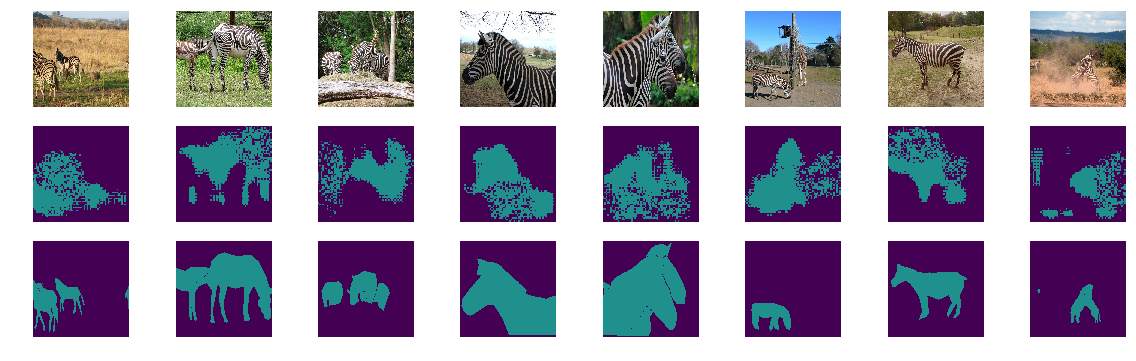

Loss on epoch 6 was: 0.60922736
Test accuracy after epoch 6 was: 0.73339523 +/- 0.06368034
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 7
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 8
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 9
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 10
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 11
testing results


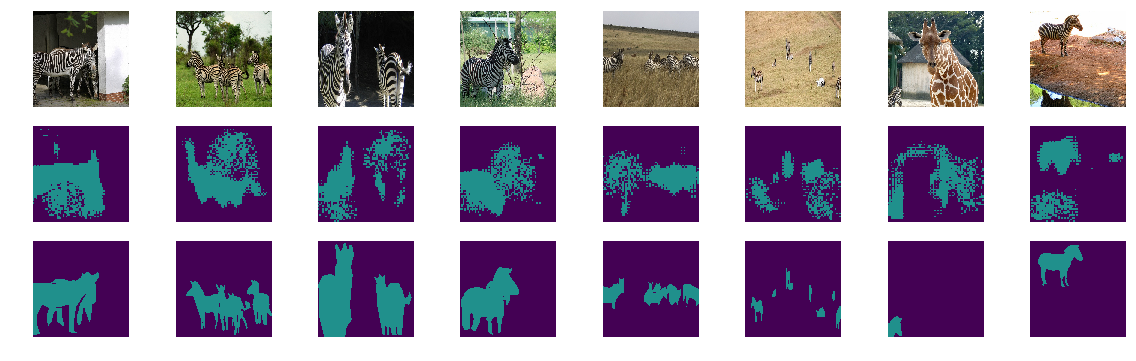

Loss on epoch 11 was: 0.33602506
Test accuracy after epoch 11 was: 0.75982382 +/- 0.08039429
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 12
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 13
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 14
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 15
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 16
testing results


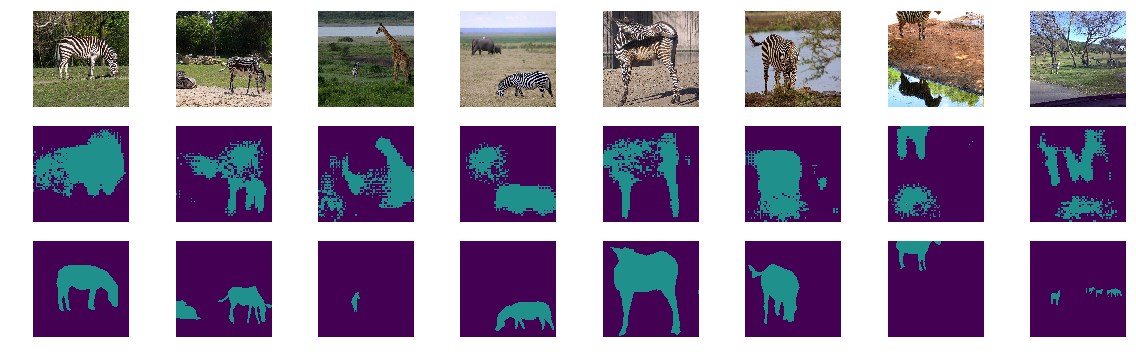

Loss on epoch 16 was: 0.31485906
Test accuracy after epoch 16 was: 0.77527944 +/- 0.08754943
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 17
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 18
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 19
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 20
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 21
testing results


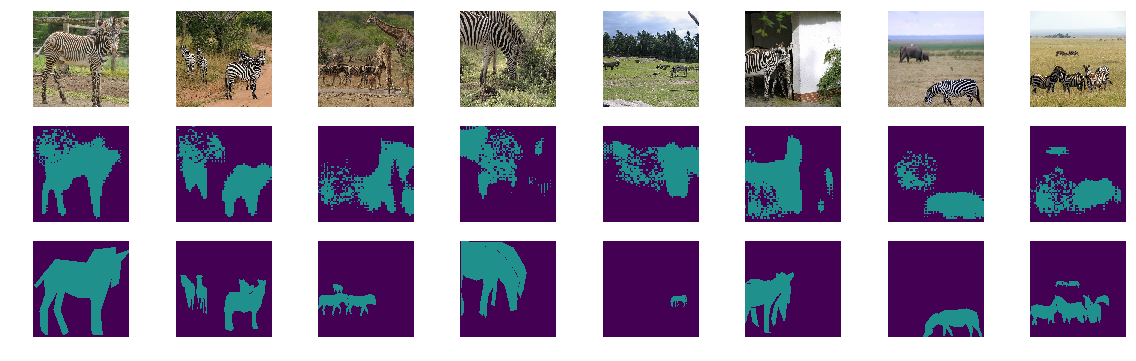

Loss on epoch 21 was: 0.36756119
Test accuracy after epoch 21 was: 0.79043146 +/- 0.07575824
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 22
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 23
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 24
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 25
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 26
testing results


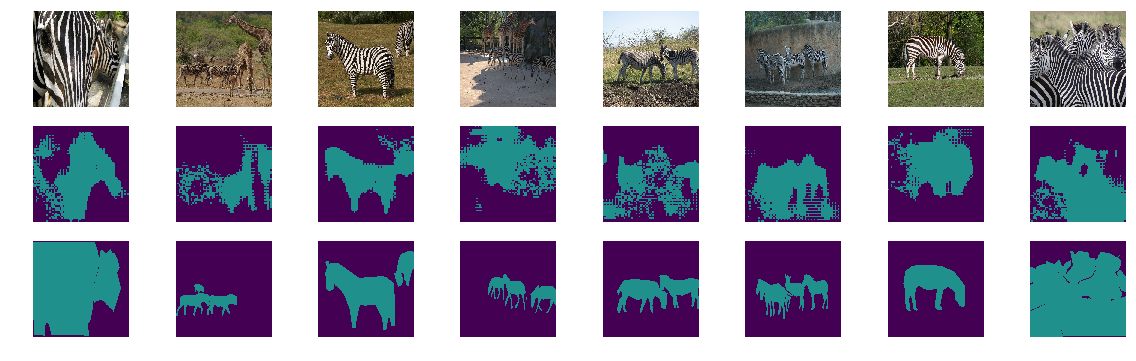

Loss on epoch 26 was: 0.21043085
Test accuracy after epoch 26 was: 0.80150093 +/- 0.07318427
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 27
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 28
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 29
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 30
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 31
testing results


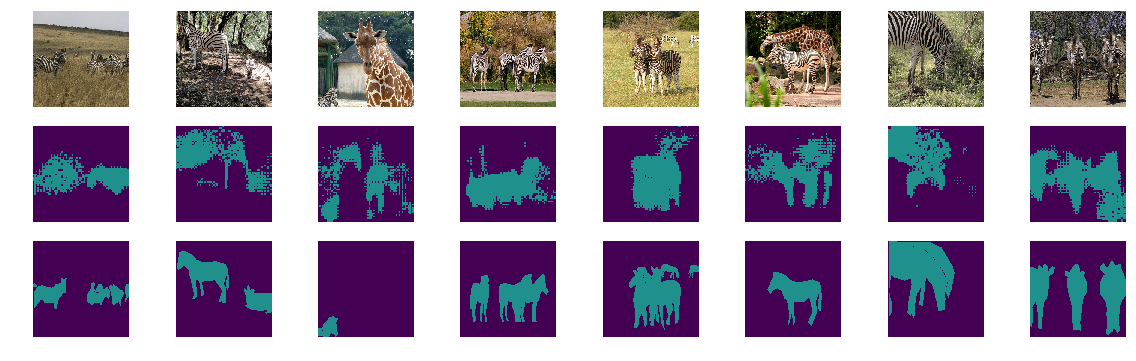

Loss on epoch 31 was: 0.29373130
Test accuracy after epoch 31 was: 0.80923625 +/- 0.08048764
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 32
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 33
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 34
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 35
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 36
testing results


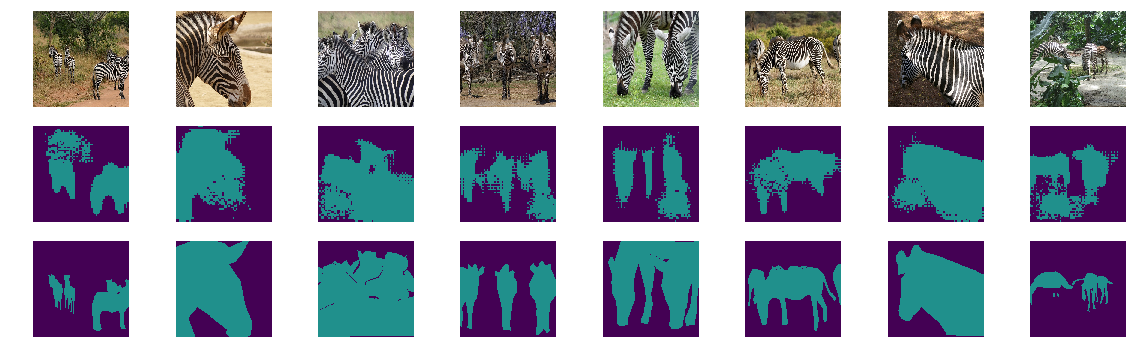

Loss on epoch 36 was: 0.32602078
Test accuracy after epoch 36 was: 0.80571733 +/- 0.07781285
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 37
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 38
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 39
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 40
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 41
testing results


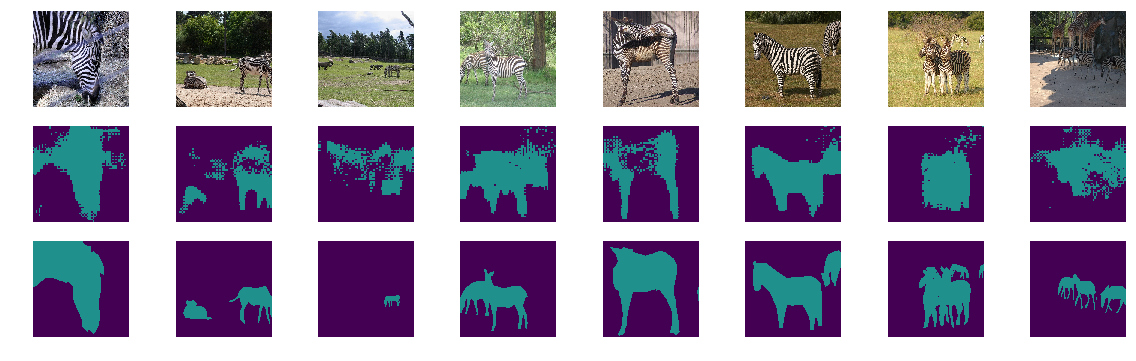

Loss on epoch 41 was: 0.20525804
Test accuracy after epoch 41 was: 0.81814826 +/- 0.07191346
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 42
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 43
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 44
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 45
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 46
testing results


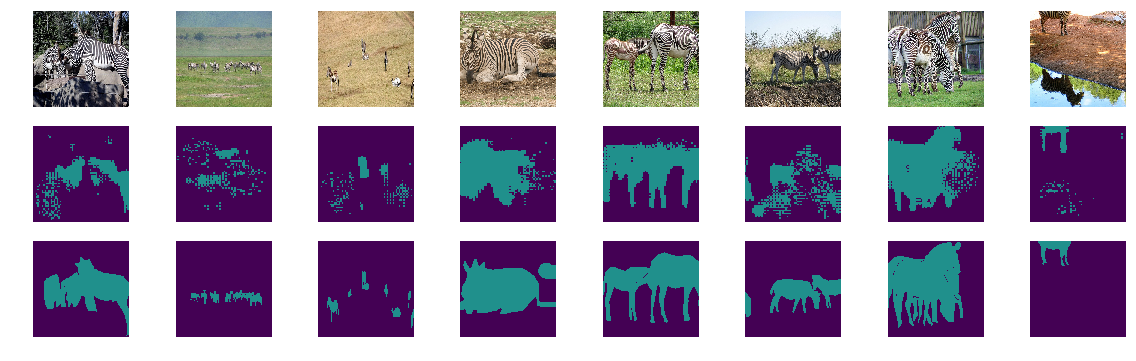

Loss on epoch 46 was: 0.33176482
Test accuracy after epoch 46 was: 0.82199525 +/- 0.08237909
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 47
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 48
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 49
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 50
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 51
testing results


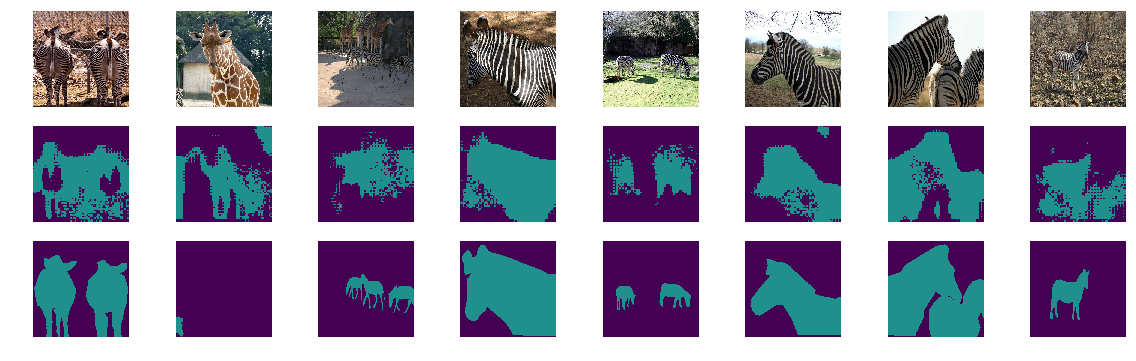

Loss on epoch 51 was: 0.26312310
Test accuracy after epoch 51 was: 0.82868832 +/- 0.07897530
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 52
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 53
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 54
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 55
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 56
testing results


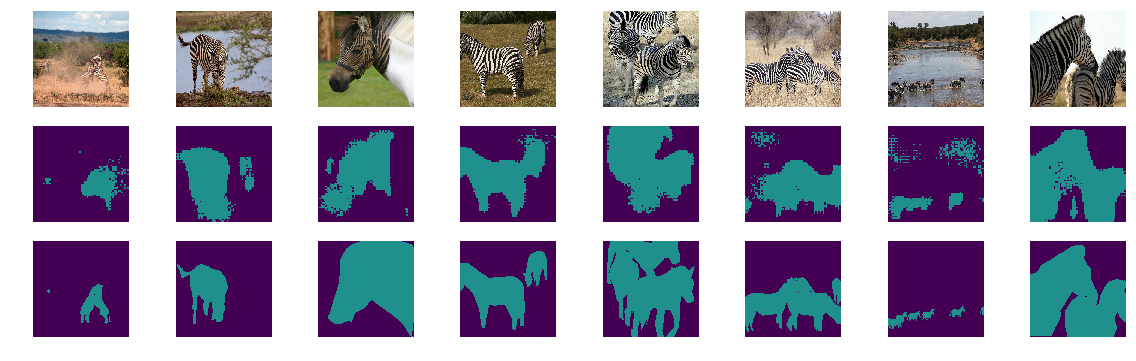

Loss on epoch 56 was: 0.25992650
Test accuracy after epoch 56 was: 0.82537511 +/- 0.07770291
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 57
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 58
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 59
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 60
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 61
testing results


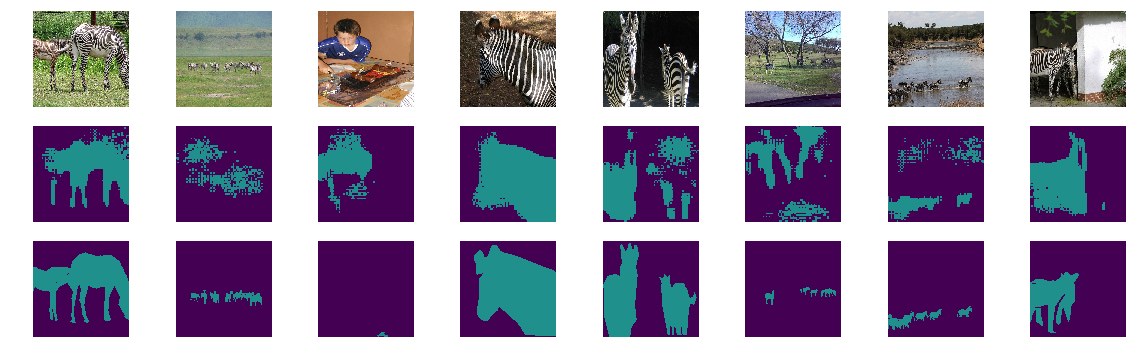

Loss on epoch 61 was: 0.25615233
Test accuracy after epoch 61 was: 0.83436961 +/- 0.06796594
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 62
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 63
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 65
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 66
testing results


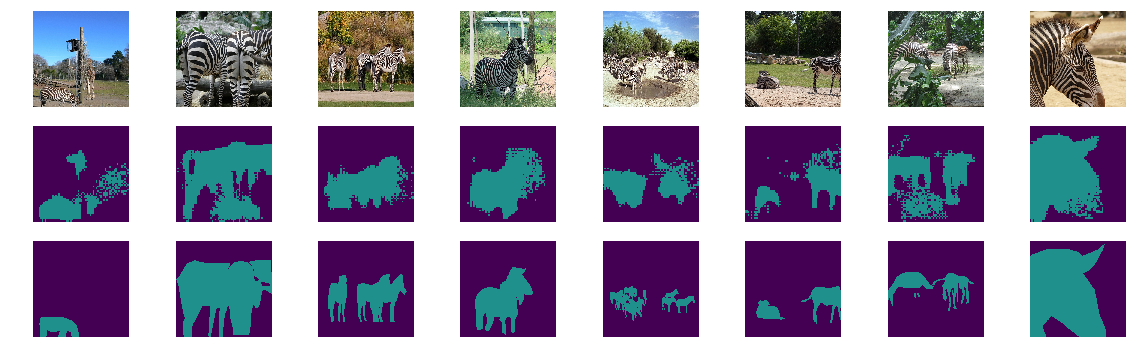

Loss on epoch 66 was: 0.18229294
Test accuracy after epoch 66 was: 0.83686601 +/- 0.07023748
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 67
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 68
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 69
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 70
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 71
testing results


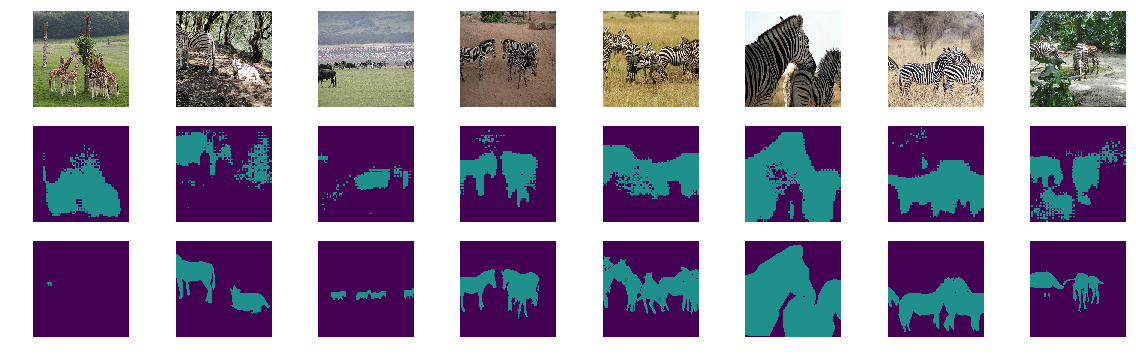

Loss on epoch 71 was: 0.26296896
Test accuracy after epoch 71 was: 0.84059324 +/- 0.07730078
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 72
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 73
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 74
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 75
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 76
testing results


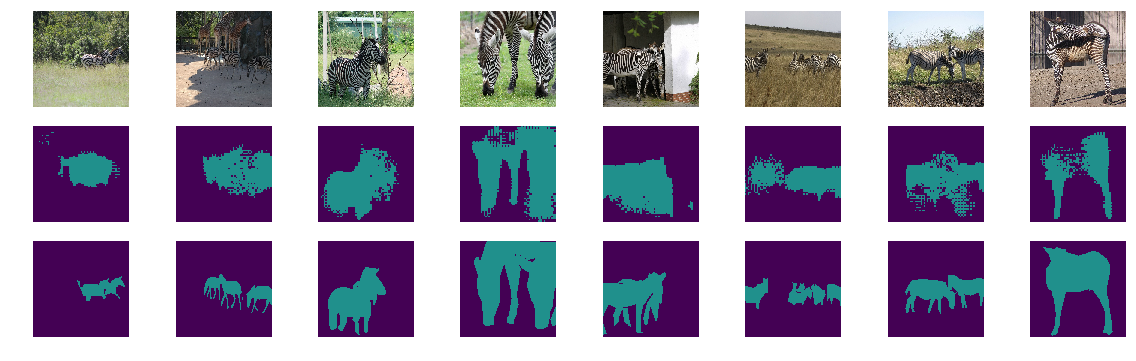

Loss on epoch 76 was: 0.24782012
Test accuracy after epoch 76 was: 0.83956988 +/- 0.07473188
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 77
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 78
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 79
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 80
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 81
testing results


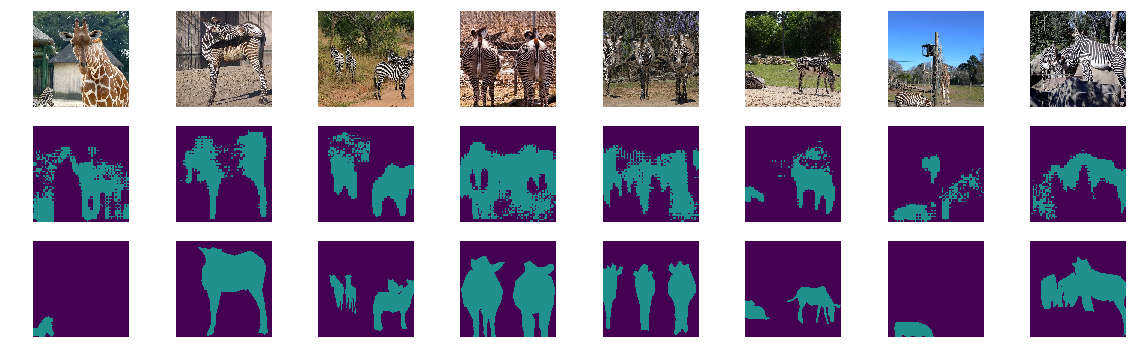

Loss on epoch 81 was: 0.20635249
Test accuracy after epoch 81 was: 0.84803474 +/- 0.06793194
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 82
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 83
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 84
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 85
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 86
testing results


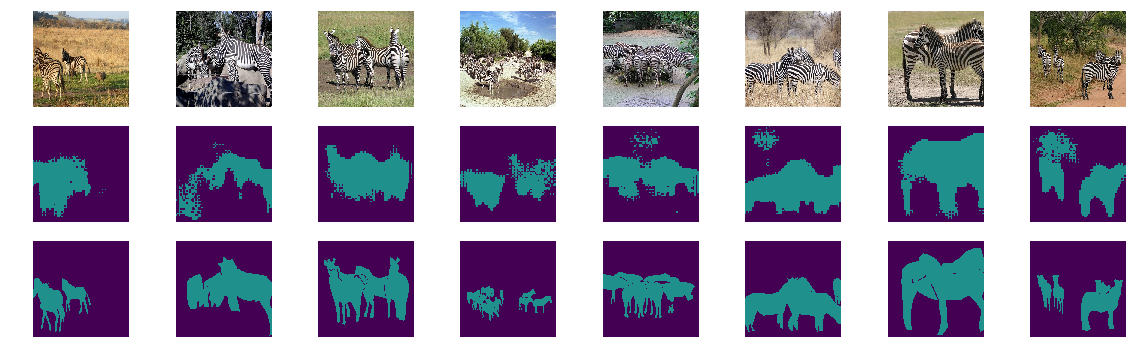

Loss on epoch 86 was: 0.24022970
Test accuracy after epoch 86 was: 0.83805098 +/- 0.07616174
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 87
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 88
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 89
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 90
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 91
testing results


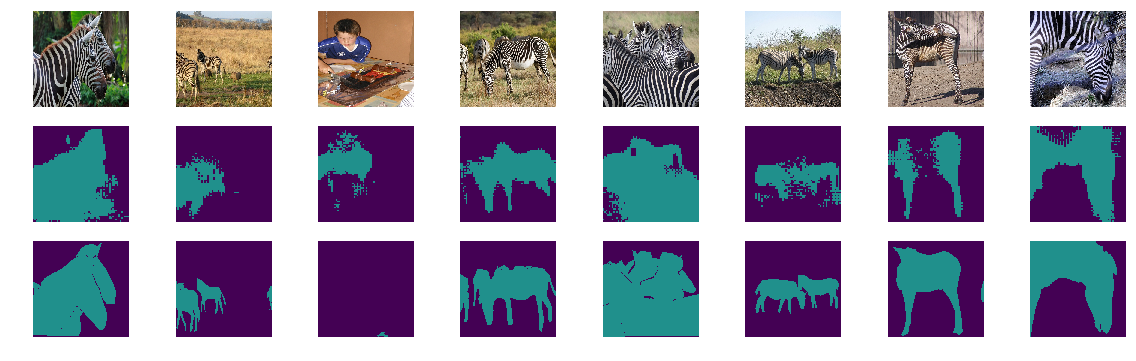

Loss on epoch 91 was: 0.23155332
Test accuracy after epoch 91 was: 0.85058208 +/- 0.07001595
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 92
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 93
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 94
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 95
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 96
testing results


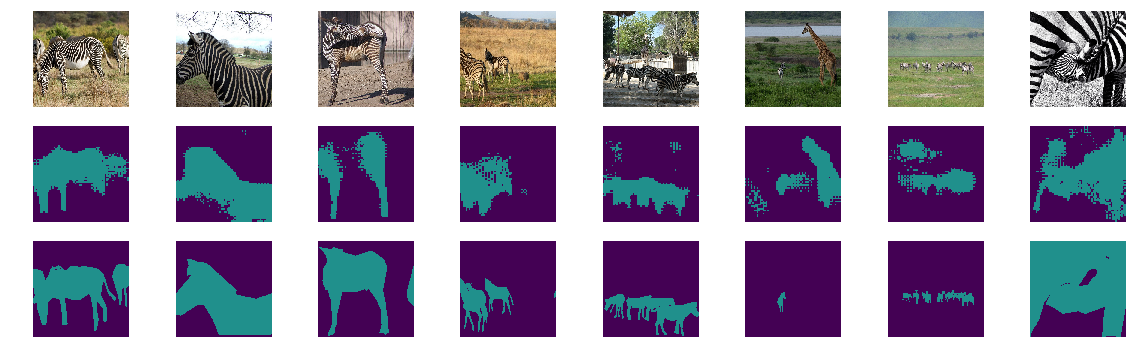

Loss on epoch 96 was: 0.28712788
Test accuracy after epoch 96 was: 0.85333573 +/- 0.06878052
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 97
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 98
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 99
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Starting Epoch # 100


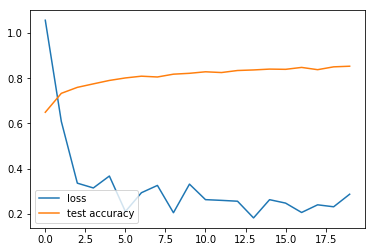

In [10]:
# generate weigth tensor for loss function 
device = 'cuda'
weight_tensor = torch.ones(len(my_net.object_label_dict)).to(device)
for key,value in my_net.object_label_dict.items():
    weight_tensor[value] = weight_dict[key]   

my_net.define_loss_function(loss_fun = nn.CrossEntropyLoss,
                               weight = weight_tensor)

my_net.train(num_epochs = 100, 
                save_checkpoint_path = '/home/jeff/Documents/checkpoints/SegNet_COCO/generic_checkpoint.pth',
                final_model_path = '/home/jeff/Documents/checkpoints/SegNet_COCO/generic_final_model.pth',
                resume = False)

In [11]:
my_net.model

drn(
  (iReLU): ReLU(inplace)
  (conv0): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (bn0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3d): Conv2d(32, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
  (bn3d): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv310): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn310): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv311): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn311): Bat